In [1]:
# Core scientific stack
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os
from glob import glob

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, colors, cbook
import seaborn as sns
import cmocean as cmocn  # if you want it; comment out if not used

# Machine Learning
from sklearn.cluster import DBSCAN, OPTICS, KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             silhouette_score,
                             pairwise_distances)
from imblearn.over_sampling import SMOTE

# Scipy
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d

# Parallelism
from joblib import Parallel, delayed

# Tensorflow
import tensorflow as tf

%matplotlib inline

2025-07-15 17:40:10.042871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 17:40:10.055631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752615610.069249 1750734 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752615610.073341 1750734 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752615610.084360 1750734 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
fname = '../testMatchups/rainFlagRemovedBuoyDataBadQualityRemovedMatchupAmbuguitiesAdded_waveAndGlorysAdded.nc'
ds = xr.open_dataset(fname)
#ds['mean_WVEL'] = np.sqrt(ds['mean_U10N_x'] **2 + ds['mean_U10N_y']**2)
data = ds.to_dataframe()
orig_df = data.copy()
df = data.copy()

df['SST-AIRT'] = df['Sea Surface Temperature (TAO)'] - df['Air Temperature (TAO)']

# C = df['mean_cosWDIR']
# S = df['mean_sinWDIR']
# R = np.sqrt(C**2 + S**2)
# sigma = np.rad2deg(np.sqrt(-np.log(R)))
# df['std_WDIR'] = sigma


In [3]:
print(list(df.columns))

['Wind Direction (TAO)', 'WDIR_QC', 'WDIR_DM', 'Wind Speed (TAO)', 'WSPD_QC', 'WSPD_DM', 'Zonal Wind Speed (TAO)', 'Meridional Wind Speed (TAO)', 'Sea Surface Temperature (TAO)', 'SST_QC', 'SST_DM', 'Relative Humidity (TAO)', 'RELH_QC', 'RELH_DM', 'Air Temperature (TAO)', 'AIRT_QC', 'AIRT_DM', 'Neutral Wind Speed at 10m (TAO)', 'Wind Speed at 10m (TAO)', 'VHM0', 'VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR', 'VMDR_SW1', 'VMDR_SW2', 'VMDR_WW', 'VPED', 'VSDX', 'VSDY', 'VTM01_SW1', 'VTM01_SW2', 'VTM01_WW', 'VTM02', 'VTM10', 'VTPK', 'WAVE_TIME', 'vo', 'zos', 'uo', 'thetao', 'so', 'GLORYS_TIME', 'mean_WSPD', 'std_WSPD', 'mean_WSPD_10N', 'std_WSPD_10N', 'mean_U10N_x', 'std_U10N_x', 'mean_U10N_y', 'std_U10N_y', 'mean_WDIR', 'std_WDIR', 'mean_cosWDIR', 'std_cosWDIR', 'mean_sinWDIR', 'std_sinWDIR', 'mean_SST', 'std_SST', 'mean_AIRT', 'std_AIRT', 'mean_SST - AIRT', 'std_SST - AIRT', 'mean_RELH', 'std_RELH', 'LATITUDE', 'LONGITUDE', 'TAO_TIME', 'Deployment index', 'num_ambiguities_speed', 'num_ambigu

In [4]:
len(df)

266786

/tmp/ipykernel_1750734/175372842.py:28: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_1750734/175372842.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_1750734/175372842.py:41: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


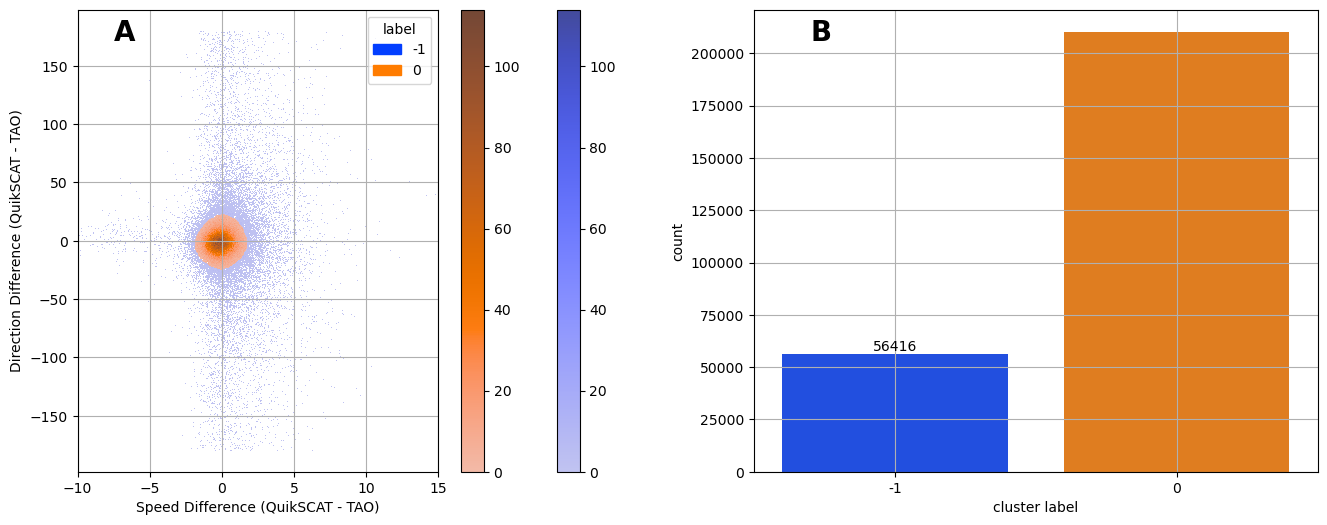

In [5]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

#dbscan = DBSCAN(eps=0.15, min_samples= 500)
dbscan = DBSCAN(eps=0.13, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [6]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([-1])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999

266786


/tmp/ipykernel_1750734/2524779619.py:152: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(data=df, x='label', palette='bright', ax=ax_count)
/tmp/ipykernel_1750734/2524779619.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_count.set_xticklabels(["Bad", "Good"])       # the new labels shown on the axis


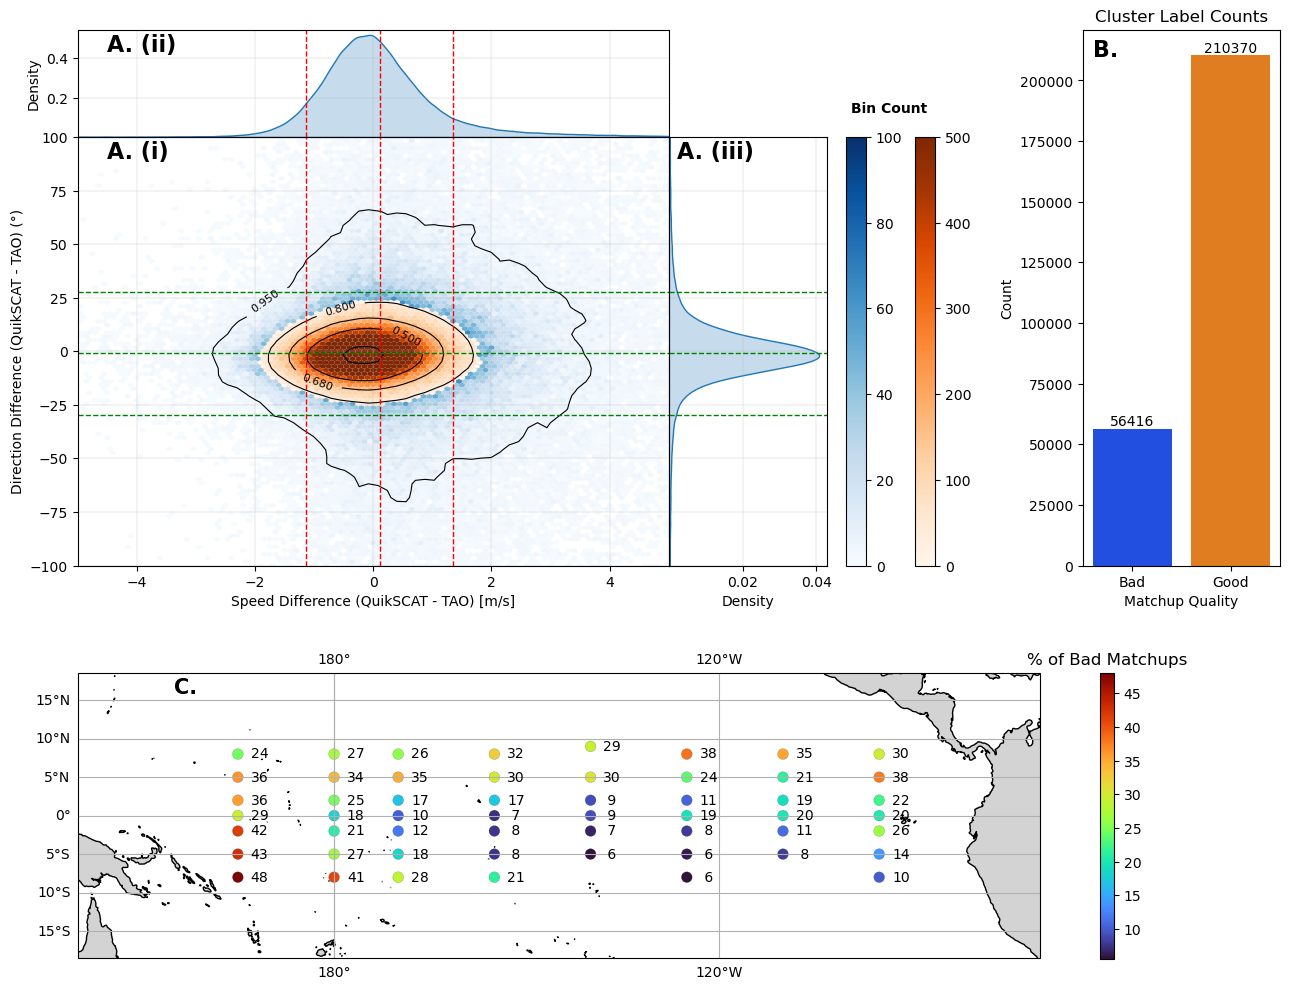

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import pandas as pd

# Example DataFrame: df must contain 'label', 'speed', 'direction'
# Replace these with your actual column names
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

# Compute mean and std
mu_speed = df[xlabel].mean()
std_speed = df[xlabel].std()
mu_dir = df[ylabel].mean()
std_dir = df[ylabel].std()

# Create overall figure
fig = plt.figure(figsize=(13, 10))
gs = gridspec.GridSpec(4, 8, width_ratios=[3, 0.8, 0.1, 0.1, 0.25, 0.1, 0.75, 1], height_ratios=[0.75, 3, 0.75, 2], wspace=0, hspace=0)

# Joint and marginals (LEFT)
ax_joint = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)
ax_cb1 = fig.add_subplot(gs[1,3])
ax_cb2 = fig.add_subplot(gs[1,5])

# Countplot (RIGHT)
ax_count = fig.add_subplot(gs[0:2, -1])  # spans both rows

# -------------------------
# 1. JOINT HISTOGRAM + KDE

colors = [plt.cm.Blues, plt.cm.Oranges]
hexcounts = [100, 100]
x_min, x_max, y_min, y_max = -5, 5, -100, 100
vmins = [0, 0]
vmaxs = [100, 500]
numcontours = 5

for i, (label, ax, ax_cb) in enumerate(zip([-1, 0], [ax_joint, ax_joint], [ax_cb1, ax_cb2])):
    df_label = df[df['label'] == label]

    hb = ax.hexbin(
        x=df_label[xlabel],
        y=df_label[ylabel],
        gridsize=hexcounts[i],
        cmap=colors[i],
        mincnt=1,
        linewidths=0.01,
        edgecolors=(0, 0, 0, 0.01),
        vmin=vmins[i],            # ← custom lower limit
        vmax=vmaxs[i],             # ← custom upper limit
        extent=(x_min, x_max, y_min, y_max)
    )

    # Extract colorbar for this label
    cbar = fig.colorbar(hb, cax=ax_cb)
    
#cbar.set_label("Bin Count")
cbar.ax.text(
    0.6, 1.05,                        # x=50% of width, y=just above the top
    "Bin Count",                     # your label
    ha='right', va='bottom',        # horizontal center, baseline aligned
    fontsize=10, fontweight='bold',  # optional styling
    transform=cbar.ax.transAxes      # relative to colorbar axis
)

# Create the Joint PDF plot and capture the returned QuadContourSet object
# KDE Grid resolution
nx, ny = 64, 64

# Data
x = df[xlabel].values
y = df[ylabel].values
xy = np.vstack([x, y])

# KDE with specified bandwidth
kde = gaussian_kde(xy, bw_method=0.1)

# Grid over which to evaluate
xx, yy = np.mgrid[x_min:x_max:nx*1j, y_min:y_max:ny*1j]
grid_coords = np.vstack([xx.ravel(), yy.ravel()])
z = kde(grid_coords).reshape(xx.shape)

# Normalize z to make it a probability surface (area ≈ 1)
dx = (x_max - x_min) / nx
dy = (y_max - y_min) / ny
z_prob = z / z.sum() #/ (dx * dy)

# Flatten and sort to get cumulative distribution
z_flat = z_prob.flatten()
z_sorted = np.sort(z_flat)[::-1]  # 🔄 descending order
z_cumsum = np.cumsum(z_sorted)

# Desired probability masses for contours
mass_levels = [0.1, 0.5, 0.68, 0.8, 0.95]
mass_levels.reverse()
levels = [z_sorted[np.searchsorted(z_cumsum, mass)] for mass in mass_levels]


#levels.sort()
# Plot contours
contour = ax_joint.contour(xx, yy, z_prob, levels=levels, colors='black', linewidths=0.8)

# Label with probability instead of density
fmt = {}
for l, s in zip(contour.levels, mass_levels):
    fmt[l] = f"{s:.3f}"  # show enclosed probability

#fmt = {level: f"{mass:.3f}" for level, mass in zip(levels, mass_levels)}

ax_joint.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=8)
# # Add labels to the contour lines
# ax_joint.clabel(contour, inline=True, fontsize=8, fmt="%.2f")

# 2. MARGINAL KDEs
sns.kdeplot(data=df, x=xlabel, fill=True, legend=False, ax=ax_marg_x, clip = (x_min, x_max) , cut = 0, bw_adjust=0.5 )
sns.kdeplot(data=df, y=ylabel, fill=True, legend=False, ax=ax_marg_y, clip = (y_min, y_max) , cut = 0, bw_adjust=0.5 )

# Remove marginal axis ticks
ax_marg_x.tick_params(bottom=False, labelbottom=False)
ax_marg_y.tick_params(left=False, labelleft=False)

# Add ±1σ lines
for x in [mu_speed - std_speed, mu_speed, mu_speed + std_speed]:
    ax_joint.axvline(x, color='red', linestyle='--', linewidth=1)
    ax_marg_x.axvline(x, color='red', linestyle='--', linewidth=1)  
    ax_marg_x.set_yticks([0.2,0.4])

for y in [mu_dir - std_dir, mu_dir, mu_dir + std_dir]:
    ax_joint.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.set_xticks([0.02,0.04])


# Axis labels
ax_joint.set_xlabel(xlabel + ' [m/s]')
ax_joint.set_ylabel(ylabel + " (°)")
ax_marg_x.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_marg_y.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_marg_x.set_xlabel(None)
ax_marg_y.set_ylabel(None)

# Label the panel
ax_joint.text(0.05, 0.95, 'A. (i)', transform=ax_joint.transAxes, fontsize=16, weight='bold')
ax_marg_x.text(0.05, 0.80, 'A. (ii)', transform=ax_marg_x.transAxes, fontsize=16, weight='bold')
ax_marg_y.text(0.05, 0.95, 'A. (iii)', transform=ax_marg_y.transAxes, fontsize=16, weight='bold')

# -------------------------
# 3. COUNTPLOT
s = sns.countplot(data=df, x='label', palette='bright', ax=ax_count)
for container in s.containers:
    s.bar_label(container)
ax_count.set_title("Cluster Label Counts")
#ax_count.set_xticks([-1, 0])                    # positions (the actual cluster labels)
ax_count.set_xticklabels(["Bad", "Good"])       # the new labels shown on the axis
ax_count.set_xlabel("Matchup Quality")
ax_count.set_ylabel("Count")
ax_count.text(0.05, 0.95, 'B.', transform=ax_count.transAxes, fontsize=16, weight='bold')

# Final adjustments

ax_joint.set_xlim(x_min, x_max)
ax_joint.set_ylim(y_min,  y_max)
ax_joint.grid(lw = 0.2)

ax_marg_x.set_xlim(x_min, x_max)
ax_marg_x.grid(lw = 0.2)

ax_marg_y.set_ylim(y_min,  y_max)
ax_marg_y.grid(lw = 0.2)

######################################################################################################################

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
dotSize = 60
slw = 0.1

latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

ax = fig.add_subplot(gs[3,:], projection=ccrs.PlateCarree(central_longitude=180))
ax.set_aspect(1.2)

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        txt = f'{badPercent:2.0f}'
        ax.text(xpos+2, lat-0.5, txt)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, badPercent]])), axis = 0)

x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C. ', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


plt.tight_layout()

#plt.savefig('clustering.pdf', dpi=100)


In [8]:
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

subDF = df.copy()

subDF['norm_xlabel'] = 2 * (subDF[xlabel] - subDF[xlabel].min()) / (subDF[xlabel].max() - subDF[xlabel].min()) - 1
subDF['norm_ylabel'] = 2 * (subDF[ylabel] - subDF[ylabel].min()) / (subDF[ylabel].max() - subDF[ylabel].min()) - 1

subDF['norm_xlabel'] = (subDF['norm_xlabel'] - subDF['norm_xlabel'].mean() + 0.01) #/ (subDF['norm_xlabel'].std())
subDF['norm_ylabel'] = (subDF['norm_ylabel'] - subDF['norm_ylabel'].mean()) #/ (subDF['norm_ylabel'].std())

# subDF['norm_xlabel'] = (subDF[xlabel] - subDF[xlabel].mean()) / (subDF[xlabel].std())
# subDF['norm_ylabel'] = (subDF[ylabel] - subDF[ylabel].mean()) / (subDF[ylabel].std())

# subDF['norm_xlabel'] = 2 * (subDF['norm_xlabel'] - subDF['norm_xlabel'].min()) / (subDF['norm_xlabel'].max() - subDF['norm_xlabel'].min()) - 1
# subDF['norm_ylabel'] = 2 * (subDF['norm_ylabel'] - subDF['norm_ylabel'].min()) / (subDF['norm_ylabel'].max() - subDF['norm_ylabel'].min()) - 1

subDF['theta'] = np.rad2deg(np.arctan2(subDF['norm_ylabel'], subDF['norm_xlabel']))
subDF['r'] = np.sqrt(subDF['norm_ylabel']**2 + subDF['norm_xlabel']**2)

subDF['org_theta'] = np.rad2deg(np.arctan2(subDF[ylabel], subDF[xlabel]))
subDF['org_r'] = np.sqrt(subDF[ylabel]**2 + subDF[xlabel]**2)

# df['theta'] = np.rad2deg(np.arctan2(df[ylabel], df[xlabel]))
# df['r'] = np.sqrt(df[ylabel]**2 + df[xlabel]**2)

# Define bin edges using NumPy (0 to 360 in 0.25° steps)
num_bins = 360*6
bin_edges = np.linspace(0, 360, num_bins, endpoint = False)  # 1441 edges for 1440 bins
right_edges = np.roll(bin_edges, -1)
right_edges[-1] = 360
bin_centers = (bin_edges + right_edges)/2
# Digitize theta into bins
subDF['org_theta_bin'] = np.digitize((subDF['org_theta'] + 360)% 360, bins=bin_edges, right=False)
subDF['org_theta_bin'] = subDF['org_theta_bin'] % num_bins  # Ensure cyclic wrap-around


subDF['theta_bin'] = np.digitize((subDF['theta'] +360) % 360, bins=bin_edges, right=False)
subDF['theta_bin'] = subDF['theta_bin'] % num_bins  # Ensure cyclic wrap-around

ssubDF = subDF.loc[df['label'] == 0]

In [9]:
bin_centers

array([8.33333333e-02, 2.50000000e-01, 4.16666667e-01, ...,
       3.59583333e+02, 3.59750000e+02, 3.59916667e+02], shape=(2160,))

In [10]:
np.max(subDF['org_theta_bin'])

np.int64(2159)

In [11]:
maxr = []
minr = []
for i in range(num_bins):
    thisDF = ssubDF.loc[ssubDF['org_theta_bin'] == i]
    maxr.append(np.max(thisDF['org_r']))
    minr.append(np.min(thisDF['org_r']))

[]

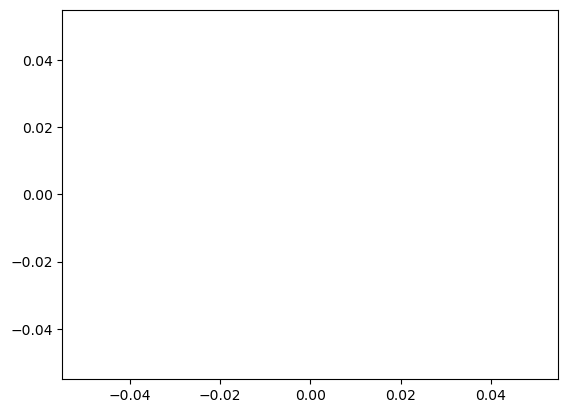

In [12]:
maxr = np.array(maxr)

plt.plot()

In [13]:
def isInsideEllipse(x, y, a, b, x1, y1):
    LHS = ((x - x1)**2)/a**2 + ((y-y1)**2)/b**2
    labels = np.array(LHS < 1, dtype=int)
    return labels

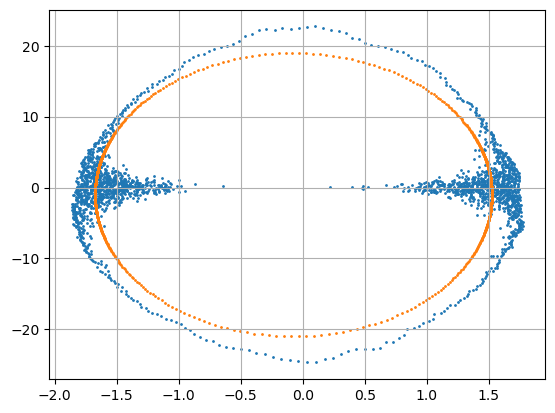

In [14]:
a = 1.6
b = 20
x1 = -0.075
y1 = -1

A = b**2 * np.cos(np.deg2rad(bin_centers))**2 +  a**2 * np.sin(np.deg2rad(bin_centers))**2
B = -2 * (x1 * np.cos(np.deg2rad(bin_centers)) * b**2 + y1 * np.sin(np.deg2rad(bin_centers)) * a**2 )  
C = x1**2* b**2 + y1**2 * a**2 - a**2 * b**2

r1 = (-B + np.sqrt(B**2 - 4* A * C))/(2* A)
#r2 = (-B - np.sqrt(B**2 - 4* A * C))/(2* A)

r = np.sqrt(a **2 * b**2 /(a**2 * np.sin(np.deg2rad(bin_centers))**2 + b**2 * np.cos(np.deg2rad(bin_centers))**2))
plt.scatter(maxr * np.cos(np.deg2rad(bin_centers)), maxr * np.sin(np.deg2rad(bin_centers)), s = 1)
#plt.scatter(r2 * np.cos(np.deg2rad(bin_centers)), r2 * np.sin(np.deg2rad(bin_centers)), s = 1)
plt.scatter(r1 * np.cos(np.deg2rad(bin_centers)), r1 * np.sin(np.deg2rad(bin_centers)), s = 1)
plt.grid()

In [ ]:
ellipseLabel = isInsideEllipse(df[xlabel].to_numpy(), df[ylabel].to_numpy(), a, b, x1, y1)
subDF['ellipseLabel'] = ellipseLabel

In [ ]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


In [ ]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10, 
                hue='ellipseLabel', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(subDF, x='ellipseLabel',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


In [ ]:
print(np.min(subDF['norm_xlabel']), np.max(subDF['norm_xlabel']))
print(np.min(subDF['norm_ylabel']), np.max(subDF['norm_ylabel']))
print(np.min(ssubDF['r']), np.max(ssubDF['r']))
print(np.min(subDF['r']), np.max(subDF['r']))

In [ ]:
plt.plot(ssubDF['r'])

In [ ]:
r1 = 0.10
r2 = 0.15
ssubDF = subDF.loc[np.logical_and(subDF['r'].to_numpy() > r1, subDF['r'].to_numpy() < r2)]

In [ ]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(ssubDF, x=xlabel, y = ylabel, #levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-5,5)

ax = axes[1]
s = sns.countplot(ssubDF, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [ ]:
mask = np.logical_and(subDF['r'].to_numpy() > r1, subDF['r'].to_numpy() < r2)
subDF = subDF.loc[~mask]

In [ ]:
list(subDF.keys())

In [ ]:
# subDF = subDF.rename_vars({'nudge_wind_speed':'model_speed',
#                            'nudge_wind_direction':'model_dir'})

subDF = subDF.rename(columns={
    'nudge_wind_speed': 'model_speed',
    'nudge_wind_direction': 'model_dir'
})

In [ ]:
subDF['label'] = subDF['label'].apply(lambda x: 1 if x == 0 else 0)

# Features to use for classification
features = ['std_WDIR',
            'std_cosWDIR', 
            'std_sinWDIR',
            'SST-AIRT',
            'mean_SST - AIRT',
            'std_SST - AIRT', 
            'Relative Humidity (TAO)',             
            'mean_RELH',             
            'mean_SST',
            'std_AIRT',
            'std_SST', 
            'mean_AIRT',
            'std_RELH',
            'Neutral Wind Speed at 10m (TAO)',
            'std_WSPD', 
            'mean_WSPD',
            'mean_WSPD_10N',
            'std_WSPD_10N',
            #'model_speed',
            #'model_dir',
            'VHM0',
             'VHM0_SW1',
             'VHM0_SW2',
             'VHM0_WW',
             'VMDR',
             'VMDR_SW1',
             'VMDR_SW2',
             'VMDR_WW',
             'VPED',
             'VSDX',
             'VSDY',
             'VTM01_SW1',
             'VTM01_SW2',
             'VTM01_WW',
             'VTM02',
             'VTM10',
             'VTPK',
             'vo',
             'zos',
             'uo',
             'thetao',
             'so'        
           ]

In [ ]:
# Split the dataset into features (X) and target (y)
X = subDF[features]

# Compute correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than threshold (e.g., 0.9)
threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop them
df_reduced = X.drop(columns=to_drop)

print(f"Removed {len(to_drop)} features: {to_drop}")


In [ ]:
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, 
            annot=True,      # show the correlation coefficients
            fmt=".2f",        # format with 2 decimal places
            cmap='coolwarm',  # color map
            square=True, 
            linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
features = list(df_reduced.columns)
features
#print(list(df.columns))

In [ ]:
X_reduced = subDF[features]
y = subDF['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Initialize and train a RandomForest Classifier
classifier = RandomForestClassifier(n_estimators=500,
                                    max_depth=None,
                                    min_samples_leaf= 2,
                                    min_samples_split= 2,
                                    max_features=0.8,  
                                    bootstrap=True,
                                    random_state=42,
                                    class_weight='balanced',
                                    n_jobs=-1)
classifier.fit(X_train_bal, y_train_bal)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier performance
print("Accuracy:", accuracy_score(y_train_bal, y_train_bal))
print("\nClassification Report:\n", classification_report(y_train_bal, y_train_bal))

# Evaluate the classifier performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from scipy.stats import randint

# # Define the parameter grid/distributions
# param_dist = {
#     'n_estimators': randint(100, 500),
#     'max_depth': [5, 10, 15, 20, 30, 50, None],
#     'min_samples_split': [2, 5, 10, 20, 30],
#     'min_samples_leaf': [1, 2, 5, 10, 20, ],
#     'max_features': ['sqrt', 'log2', 0.5, 0.7, None],
#     'bootstrap': [True, False],
#     'class_weight': ['balanced']
# }

# # Instantiate the Random Forest
# rf = RandomForestClassifier(random_state=42)

# # Set up the random search
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=50,               # number of combinations to try
#     cv=5,                    # 5-fold cross-validation
#     scoring='f1_macro',      # or 'accuracy', 'roc_auc', etc.
#     n_jobs=-1,               # use all cores
#     random_state=42,
#     verbose=2
# )

# # Fit to training data
# random_search.fit(X_train, y_train)

# # Best parameters found
# print("Best hyperparameters:", random_search.best_params_)
# print("Best CV score:", random_search.best_score_)


In [ ]:
#importances = best_model.feature_importances_
importances = classifier.feature_importances_

# Feature names (must match your input order)
feature_names = X_train.columns  

# Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (cuML)')
plt.gca().invert_yaxis()  # Most important at top

In [ ]:
import joblib

joblib.dump(classifier, "random_forest_goodBadMatchup.joblib")

# # load
# loaded_rf = joblib.load("my_random_forest.joblib")

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.histplot(df.loc[df['label'] == -1], x=xlabel, y = ylabel, bins=1000, 
            #hue='label', common_norm=True, cbar = True,
            palette = sns.color_palette("bright"), ax = ax)
ax.set_ylim([-30,30])
ax.set_xlim([-3,3])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Features and Target
# features = ['std_cosWDIR', 
#             'std_sinWDIR',
#             'SST-AIRT',
#             'mean_SST - AIRT',
#             'std_SST - AIRT', 
#             'Relative Humidity (TAO)',             
#             'mean_RELH',             
#             'mean_SST',
#             'std_AIRT',
#             'std_SST', 
#             'mean_AIRT',
#             'std_RELH',
#             'Neutral Wind Speed at 10m (TAO)',
#             'std_WSPD', 
#             'mean_WSPD',
#             'mean_WSPD_10N',
#             'std_WSPD_10N',
#             #'model_speed',
#             #'model_dir',
#             'VHM0',
#              'VHM0_SW1',
#              'VHM0_SW2',
#              'VHM0_WW',
#              'VMDR',
#              'VMDR_SW1',
#              'VMDR_SW2',
#              'VMDR_WW',
#              'VPED',
#              'VSDX',
#              'VSDY',
#              'VTM01_SW1',
#              'VTM01_SW2',
#              'VTM01_WW',
#              'VTM02',
#              'VTM10',
#              'VTPK',
#              'vo',
#              'zos',
#              'uo',
#              'thetao',
#              'so' ]

X = subDF[features].values
y = subDF['label'].values

# X = df[features].values
# y = df['label'].values


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE for Class Balancing
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)

# Build the Neural Network Model
# Best Hyperparameters:
# units_input: 96
# dropout_input: 0.1
# num_layers: 3
# units_0: 80
# dropout_0: 0.2
# lr: 0.0007730555977073046
# units_1: 80
# dropout_1: 0.0
# units_2: 96
# dropout_2: 0.30000000000000004
model = Sequential([
    Dense(96, activation='relu', input_shape=(X_train_bal.shape[1],)),
    Dropout(0.1),
    Dense(80, activation='relu'),
    Dropout(0.2),
    Dense(80, activation='relu'),
    Dropout(0.0),
    Dense(96, activation='relu'),  
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping to Prevent Overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(X_train_bal, y_train_bal, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=64, 
                    callbacks=[early_stop],
                    verbose=1)

#plot_training_curves(history)

# Predictions
y_pred_train_prob = model.predict(X_train).flatten()
y_pred_train = (y_pred_train_prob > 0.5).astype(int)

y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print("Training Accuracy (Last Epoch):", history.history['accuracy'][-1])
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# Save
np.save('X_train.npy', X_train_bal)

In [ ]:
# Predictions
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print("Training Accuracy (Last Epoch):", history.history['accuracy'][-1])
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
model.save('my_tf_model.h5')     # TensorFlow SavedModel format (folder)

In [ ]:
# Predictions
X_new = df[features]
y_pred_prob_all = model.predict(scaler.transform(X_new)).flatten()
y_pred_all = (y_pred_prob_all > 0.5).astype(int)

# Evaluation
print("Training Accuracy (Last Epoch):", history.history['accuracy'][-1])
print("\nTest Accuracy:", accuracy_score(df['label']+1, y_pred_all))
print("\nClassification Report:\n", classification_report(df['label']+1, y_pred_all))

In [ ]:
# Example DataFrame: df must contain 'label', 'speed', 'direction'
# Replace these with your actual column names
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

# Compute mean and std
mu_speed = df[xlabel].mean()
std_speed = df[xlabel].std()
mu_dir = df[ylabel].mean()
std_dir = df[ylabel].std()

### label the data from deep learning
df['ML_label'] = y_pred_all

# Create overall figure
fig = plt.figure(figsize=(13, 10))
gs = gridspec.GridSpec(4, 8, width_ratios=[3, 0.8, 0.1, 0.1, 0.25, 0.1, 0.75, 1], height_ratios=[0.75, 3, 0.75, 2], wspace=0, hspace=0)

# Joint and marginals (LEFT)
ax_joint = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)
ax_cb1 = fig.add_subplot(gs[1,3])
ax_cb2 = fig.add_subplot(gs[1,5])

# Countplot (RIGHT)
ax_count = fig.add_subplot(gs[0:2, -1])  # spans both rows

# -------------------------
# 1. JOINT HISTOGRAM + KDE

colors = [plt.cm.Blues, plt.cm.Oranges]
hexcounts = [100, 100]
x_min, x_max, y_min, y_max = -5, 5, -100, 100
vmins = [0, 0]
vmaxs = [100, 500]
numcontours = 5

for i, (label, ax, ax_cb) in enumerate(zip([0, 1], [ax_joint, ax_joint], [ax_cb1, ax_cb2])):
    df_label = df[df['ML_label'] == label]

    hb = ax.hexbin(
        x=df_label[xlabel],
        y=df_label[ylabel],
        gridsize=hexcounts[i],
        cmap=colors[i],
        mincnt=1,
        linewidths=0.01,
        edgecolors=(0, 0, 0, 0.01),
        vmin=vmins[i],            # ← custom lower limit
        vmax=vmaxs[i],             # ← custom upper limit
        extent=(x_min, x_max, y_min, y_max)
    )

    # Extract colorbar for this label
    cbar = fig.colorbar(hb, cax=ax_cb)
    
#cbar.set_label("Bin Count")
cbar.ax.text(
    0.6, 1.05,                        # x=50% of width, y=just above the top
    "Bin Count",                     # your label
    ha='right', va='bottom',        # horizontal center, baseline aligned
    fontsize=10, fontweight='bold',  # optional styling
    transform=cbar.ax.transAxes      # relative to colorbar axis
)

# Create the Joint PDF plot and capture the returned QuadContourSet object
# KDE Grid resolution
nx, ny = 64, 64

# Data
x = df[xlabel].values
y = df[ylabel].values
xy = np.vstack([x, y])

# KDE with specified bandwidth
kde = gaussian_kde(xy, bw_method=0.1)

# Grid over which to evaluate
xx, yy = np.mgrid[x_min:x_max:nx*1j, y_min:y_max:ny*1j]
grid_coords = np.vstack([xx.ravel(), yy.ravel()])
z = kde(grid_coords).reshape(xx.shape)

# Normalize z to make it a probability surface (area ≈ 1)
dx = (x_max - x_min) / nx
dy = (y_max - y_min) / ny
z_prob = z / z.sum() #/ (dx * dy)

# Flatten and sort to get cumulative distribution
z_flat = z_prob.flatten()
z_sorted = np.sort(z_flat)[::-1]  # 🔄 descending order
z_cumsum = np.cumsum(z_sorted)

# Desired probability masses for contours
mass_levels = [0.1, 0.5, 0.68, 0.8, 0.95]
mass_levels.reverse()
levels = [z_sorted[np.searchsorted(z_cumsum, mass)] for mass in mass_levels]


#levels.sort()
# Plot contours
contour = ax_joint.contour(xx, yy, z_prob, levels=levels, colors='black', linewidths=0.8)

# Label with probability instead of density
fmt = {}
for l, s in zip(contour.levels, mass_levels):
    fmt[l] = f"{s:.3f}"  # show enclosed probability

#fmt = {level: f"{mass:.3f}" for level, mass in zip(levels, mass_levels)}

ax_joint.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=8)
# # Add labels to the contour lines
# ax_joint.clabel(contour, inline=True, fontsize=8, fmt="%.2f")

# 2. MARGINAL KDEs
sns.kdeplot(data=df, x=xlabel, fill=True, legend=False, ax=ax_marg_x, clip = (x_min, x_max) , cut = 0, bw_adjust=0.5 )
sns.kdeplot(data=df, y=ylabel, fill=True, legend=False, ax=ax_marg_y, clip = (y_min, y_max) , cut = 0, bw_adjust=0.5 )

# Remove marginal axis ticks
ax_marg_x.tick_params(bottom=False, labelbottom=False)
ax_marg_y.tick_params(left=False, labelleft=False)

# Add ±1σ lines
for x in [mu_speed - std_speed, mu_speed, mu_speed + std_speed]:
    ax_joint.axvline(x, color='red', linestyle='--', linewidth=1)
    ax_marg_x.axvline(x, color='red', linestyle='--', linewidth=1)  
    ax_marg_x.set_yticks([0.2,0.4])

for y in [mu_dir - std_dir, mu_dir, mu_dir + std_dir]:
    ax_joint.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.set_xticks([0.02,0.04])


# Axis labels
ax_joint.set_xlabel(xlabel + ' [m/s]')
ax_joint.set_ylabel(ylabel + " (°)")
ax_marg_x.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_marg_y.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_marg_x.set_xlabel(None)
ax_marg_y.set_ylabel(None)

# Label the panel
ax_joint.text(0.05, 0.95, 'A. (i)', transform=ax_joint.transAxes, fontsize=16, weight='bold')
ax_marg_x.text(0.05, 0.80, 'A. (ii)', transform=ax_marg_x.transAxes, fontsize=16, weight='bold')
ax_marg_y.text(0.05, 0.95, 'A. (iii)', transform=ax_marg_y.transAxes, fontsize=16, weight='bold')

# -------------------------
# 3. COUNTPLOT
s = sns.countplot(data=df, x='ML_label', palette='bright', ax=ax_count)
for container in s.containers:
    s.bar_label(container)
ax_count.set_title("Cluster Label Counts")
#ax_count.set_xticks([-1, 0])                    # positions (the actual cluster labels)
ax_count.set_xticklabels(["Bad", "Good"])       # the new labels shown on the axis
ax_count.set_xlabel("Matchup Quality")
ax_count.set_ylabel("Count")
ax_count.text(0.05, 0.95, 'B.', transform=ax_count.transAxes, fontsize=16, weight='bold')

# Final adjustments

ax_joint.set_xlim(x_min, x_max)
ax_joint.set_ylim(y_min,  y_max)
ax_joint.grid(lw = 0.2)

ax_marg_x.set_xlim(x_min, x_max)
ax_marg_x.grid(lw = 0.2)

ax_marg_y.set_ylim(y_min,  y_max)
ax_marg_y.grid(lw = 0.2)

######################################################################################################################

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
dotSize = 60
slw = 0.1

latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

ax = fig.add_subplot(gs[3,:], projection=ccrs.PlateCarree(central_longitude=180))
ax.set_aspect(1.2)

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        txt = f'{badPercent:2.0f}'
        ax.text(xpos+2, lat-0.5, txt)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, badPercent]])), axis = 0)

x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C. ', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


plt.tight_layout()

#plt.savefig('clustering.pdf', dpi=100)


In [ ]:
fig,  axes = plt.subplots(nrows = 1, ncols = 4, figsize=(12,3), sharex = True, sharey = True)
labelFS = 12



ax = axes[0]
s = sns.histplot( df.loc[df["ML_label"] == 1], x=xlabel, y = ylabel, bins = (100,100), cbar = True, ax = ax)
ax.set_xlim(-10,10)
ax.set_ylim(-180,180)
ax.grid()
ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)

ax = axes[1]
s = sns.histplot( df.loc[df["ML_label"] == 0], x=xlabel, y = ylabel, bins = (100,100), color = 'orange', cbar = True, ax = ax)
ax.set_xlim(-10,10)
ax.set_ylim(-180,180)
ax.grid()
ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)

ax = axes[2]
s = sns.histplot( df.loc[df["label"] == 0], x=xlabel, y = ylabel, bins = (20,20), cbar = True, ax = ax)
ax.set_xlim(-10,10)
ax.set_ylim(-180,180)
ax.grid()
ax.text(0.1, 0.95, 'C', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)

ax = axes[3]
s = sns.histplot( df.loc[df["label"] == -1], x=xlabel, y = ylabel, bins = (100,100), color = 'orange', cbar = True, ax = ax)
ax.set_xlim(-10,10)
ax.set_ylim(-180,180)
ax.grid()
ax.text(0.1, 0.95, 'D', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = labelFS)

plt.tight_layout()
#plt.savefig('goodBadMatchupPredictedOnASCATtrainedOnQuikSCAT.pdf', dpi=100)

In [ ]:
X_reduced = df[features]
y = y_pred_all #subDF['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Initialize and train a RandomForest Classifier
# classifier = RandomForestClassifier(n_estimators=300,
#                                     max_depth=30,
#                                     min_samples_leaf=3,
#                                     min_samples_split=5,
#                                     bootstrap=True,
#                                     random_state=42,
#                                     class_weight='balanced',
#                                     n_jobs=-1)
classifier = RandomForestClassifier(n_estimators=500,
                                    max_depth=None,
                                    min_samples_leaf= 2,
                                    min_samples_split= 2,
                                    max_features=0.8,  
                                    bootstrap=True,
                                    random_state=42,
                                    class_weight='balanced',
                                    n_jobs=-1)

classifier.fit(X_train_bal, y_train_bal)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier performance
print("Accuracy:", accuracy_score(y_train_bal, y_train_bal))
print("\nClassification Report:\n", classification_report(y_train_bal, y_train_bal))

# Evaluate the classifier performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
#importances = best_model.feature_importances_
importances = classifier.feature_importances_

# Feature names (must match your input order)
feature_names = X_train.columns  

# Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (cuML)')
plt.gca().invert_yaxis()  # Most important at top

In [ ]:
import joblib

joblib.dump(classifier, "random_forest_goodBadMatchup_firstNeuralNet.joblib")

In [ ]:
import keras_tuner as kt  # If you're using Keras Tuner v1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_dim = X_train_bal.shape[1]

def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_input', 16, 128, step=16), activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(hp.Float('dropout_input', 0.0, 0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(hp.Int(f'units_{i}', 16, 128, step=16), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='wind_matchup_tuning'
)

tuner.search(X_train_bal, y_train_bal,
             validation_split=0.2,
             epochs=50,
             batch_size=256,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Get best model
best_model = tuner.get_best_models(1)[0]
best_model.evaluate(X_test, y_test)


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

# Print all selected hyperparameter values
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the full summary of trials as a DataFrame
tuner_results = tuner.oracle.get_best_trials(num_trials=10)
results_data = []

for trial in tuner_results:
    trial_summary = trial.metrics.get_last_value('val_accuracy')
    trial_params = trial.hyperparameters.values
    trial_params['val_accuracy'] = trial_summary
    results_data.append(trial_params)

results_df = pd.DataFrame(results_data)

# Plot Validation Accuracy vs. Number of Neurons in Input Layer
plt.figure(figsize=(8, 5))
plt.scatter(results_df['units_input'], results_df['val_accuracy'], c='blue')
plt.xlabel('Neurons in Input Layer')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Input Layer Size')
plt.grid(True)
plt.show()

# Plot Validation Accuracy vs. Learning Rate
plt.figure(figsize=(8, 5))
plt.scatter(results_df['lr'], results_df['val_accuracy'], c='green')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Learning Rate')
plt.grid(True)
plt.show()

# If you want to explore the DataFrame directly
print(results_df.sort_values(by='val_accuracy', ascending=False))


In [ ]:
# Predictions
y_pred_prob = best_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print("Training Accuracy (Last Epoch):", history.history['accuracy'][-1])
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))